<a href="https://colab.research.google.com/github/AfnanSD/learning-machine-learning/blob/main/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 41.97 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b8b6fac1450>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [52]:
# Setup the model with pretrained weights and send it to the target device
# model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

model_0 # uncomment to output (it's very long)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 10.922 seconds


### Make predictions on the entire test dataset with the model

In [11]:
# TODO

# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
y_preds_prob = []

model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    y_pred_prob = torch.softmax(y_logit, dim=1) #predictions from logits -> prediction probabilities
    y_pred = y_pred_prob.argmax(dim=1) #prediction probabilities -> predictions labels
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    y_preds_prob.append(y_pred_prob.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_prob_tensor = torch.cat(y_preds_prob)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
y_pred_tensor, class_names[y_pred_tensor[0]]

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
         2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
         2, 2, 2]),
 'pizza')

In [13]:
y_pred_prob_tensor

tensor([[0.7349, 0.1722, 0.0928],
        [0.6056, 0.1457, 0.2488],
        [0.4661, 0.4595, 0.0743],
        [0.7870, 0.1355, 0.0775],
        [0.4022, 0.3401, 0.2577],
        [0.4828, 0.3062, 0.2110],
        [0.7079, 0.2314, 0.0607],
        [0.5895, 0.2102, 0.2003],
        [0.5993, 0.1680, 0.2328],
        [0.7782, 0.1699, 0.0519],
        [0.3718, 0.3841, 0.2441],
        [0.4088, 0.3982, 0.1930],
        [0.1500, 0.4148, 0.4351],
        [0.2519, 0.4259, 0.3222],
        [0.4743, 0.3113, 0.2145],
        [0.3626, 0.2105, 0.4269],
        [0.6850, 0.1345, 0.1805],
        [0.4504, 0.3291, 0.2205],
        [0.6941, 0.2423, 0.0636],
        [0.7701, 0.1434, 0.0865],
        [0.4698, 0.4035, 0.1267],
        [0.4470, 0.3937, 0.1593],
        [0.6159, 0.2325, 0.1515],
        [0.5400, 0.2328, 0.2273],
        [0.3764, 0.1789, 0.4447],
        [0.0318, 0.9124, 0.0557],
        [0.2118, 0.6370, 0.1512],
        [0.1403, 0.4601, 0.3996],
        [0.0613, 0.8453, 0.0934],
        [0.263

In [14]:
# Take the maximum along each
y_max_pred_prob_tensor = torch.max(y_pred_prob_tensor, dim=1).values
y_max_pred_prob_tensor

tensor([0.7349, 0.6056, 0.4661, 0.7870, 0.4022, 0.4828, 0.7079, 0.5895, 0.5993,
        0.7782, 0.3841, 0.4088, 0.4351, 0.4259, 0.4743, 0.4269, 0.6850, 0.4504,
        0.6941, 0.7701, 0.4698, 0.4470, 0.6159, 0.5400, 0.4447, 0.9124, 0.6370,
        0.4601, 0.8453, 0.4477, 0.7608, 0.7831, 0.6924, 0.7310, 0.4523, 0.8943,
        0.8424, 0.5342, 0.4057, 0.7878, 0.7858, 0.7825, 0.8590, 0.6751, 0.4496,
        0.4718, 0.5803, 0.6143, 0.7607, 0.8028, 0.5659, 0.3818, 0.4780, 0.5049,
        0.8034, 0.4039, 0.4753, 0.4316, 0.4884, 0.5660, 0.4312, 0.6601, 0.5831,
        0.4869, 0.5095, 0.4432, 0.4640, 0.6263, 0.4139, 0.6240, 0.5470, 0.5397,
        0.5300, 0.4501, 0.7518])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [15]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.5 MB/s eta 0:00:00
mlxtend version: 0.23.3


In [16]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.3


In [17]:
test_data = datasets.ImageFolder(test_dir, transform=simple_transform)

In [18]:
test_data[0]

(tensor([[[-2.1179, -2.1179, -2.0837,  ..., -1.6384, -1.7240, -1.7925],
          [-2.0837, -2.0837, -2.0494,  ..., -1.6555, -1.7240, -1.7925],
          [-1.9467, -1.9809, -1.9638,  ..., -1.6555, -1.7240, -1.7925],
          ...,
          [-2.0323, -2.0323, -2.0323,  ..., -1.7240, -1.7412, -1.7583],
          [-2.0323, -2.0323, -2.0323,  ..., -1.7240, -1.7412, -1.7754],
          [-2.0323, -2.0323, -2.0323,  ..., -1.7240, -1.7583, -1.7754]],
 
         [[-2.0007, -2.0007, -2.0182,  ..., -1.9132, -1.9307, -1.9482],
          [-2.0182, -2.0182, -2.0007,  ..., -1.9307, -1.9482, -1.9657],
          [-2.0182, -2.0182, -2.0182,  ..., -1.9307, -1.9657, -1.9832],
          ...,
          [-2.0182, -2.0182, -2.0182,  ..., -1.9482, -1.9657, -1.9657],
          [-2.0182, -2.0182, -2.0182,  ..., -1.9482, -1.9657, -1.9482],
          [-2.0182, -2.0182, -2.0182,  ..., -1.9482, -1.9482, -1.9482]],
 
         [[-1.7870, -1.8044, -1.8044,  ..., -1.7870, -1.7522, -1.7522],
          [-1.7347, -1.7696,

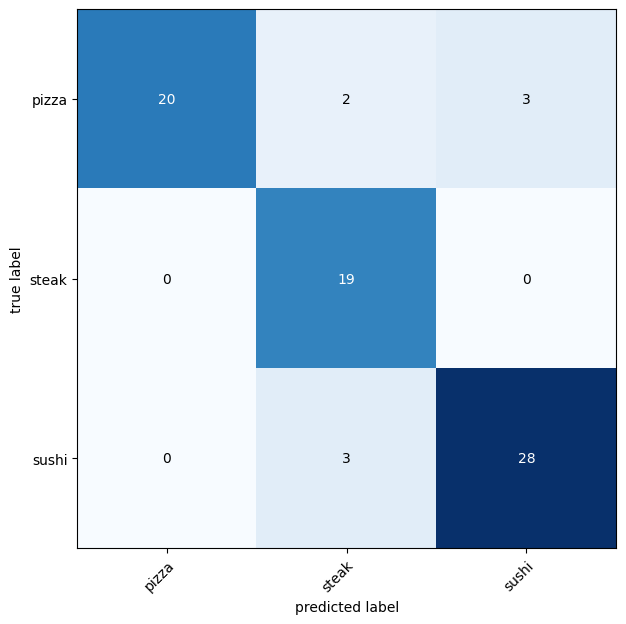

In [19]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


target_tensor = torch.tensor(test_data.targets) #test data is list, should be converted to PyTorch tensor first since confmat excpect it

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=target_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [20]:
# Loop through dataset and collect data
X = []
y = []

for image, label in test_data:
  X.append(image)
  y.append(label)

In [21]:
len(y)

75

In [22]:
# v = y_pred_tensor.tolist()
len(X), len(y), len(y_pred_tensor.tolist()), len(y_max_pred_prob_tensor.tolist())

(75, 75, 75, 75)

In [23]:
X[0].shape

torch.Size([3, 224, 224])

In [24]:
# TODO
import pandas as pd

# Create a DataFrame with sample, label, prediction, pred prob
# Example dictionary
data = {
    "sample": X, #images from the dataset
    "label": y, #label from the dataset
    "prediction": y_pred_tensor.tolist(),
    "pred_prob": y_max_pred_prob_tensor.tolist()
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df.drop(columns=["sample"]).head())

   label  prediction  pred_prob
0      0           0   0.734949
1      0           0   0.605592
2      0           0   0.466127
3      0           0   0.786989
4      0           0   0.402151


In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sample      75 non-null     object 
 1   label       75 non-null     int64  
 2   prediction  75 non-null     int64  
 3   pred_prob   75 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.5+ KB
None


In [26]:
# Sort DataFrame by correct (does label == prediction)
incorrect_df = df[df["label"] != df["prediction"]]
print(incorrect_df.drop(columns=["sample"]))

    label  prediction  pred_prob
10      0           1   0.384089
12      0           2   0.435139
13      0           1   0.425909
15      0           2   0.426874
24      0           2   0.444701
44      2           1   0.449595
55      2           1   0.403894
70      2           1   0.546966


In [27]:
# Sort DataFrame by pred prob (descending)
incorrect_df_desc = incorrect_df.sort_values(by="pred_prob", ascending=False)
print(incorrect_df_desc.drop(columns=["sample"]))

    label  prediction  pred_prob
70      2           1   0.546966
44      2           1   0.449595
24      0           2   0.444701
12      0           2   0.435139
15      0           2   0.426874
13      0           1   0.425909
55      2           1   0.403894
10      0           1   0.384089


In [28]:
def plot_image(
    tensor_image: torch.tensor,
    prob: float,
    prediction: int
  ):
  # Rearrange dimensions to [height, width, channels]
  image_np = tensor_image.permute(1, 2, 0).numpy()

  #Plot image with predicted label and probability
  plt.figure()
  plt.imshow(image_np)
  plt.title(f"Pred: {class_names[prediction]} | Prob: {prob.max():.3f}")
  plt.axis(False);

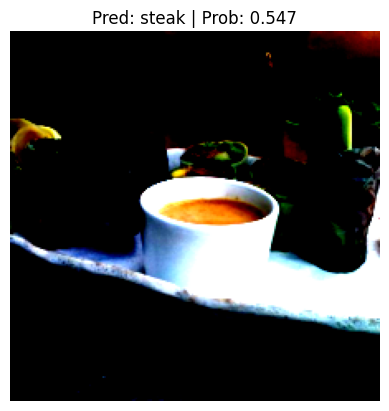

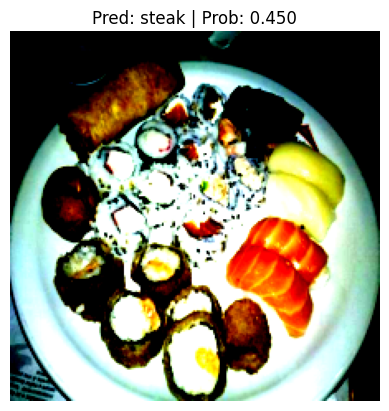

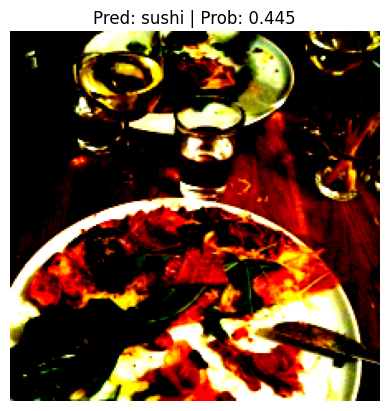

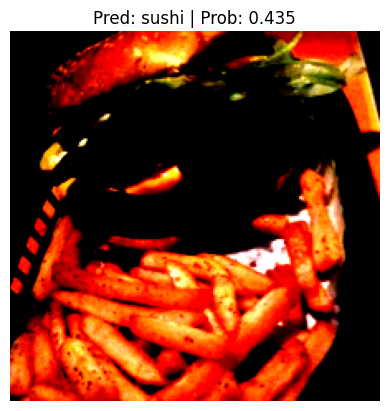

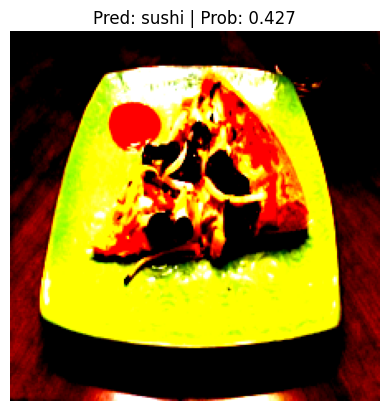

In [29]:
# Plot the top 5 "most wrong" image predictions
most_wront_5 = incorrect_df_desc.head(5)
# most_wront_5.drop(columns=["sample"])
for i in range(5):
    row = most_wront_5.iloc[i]
    plot_image(
        tensor_image=row["sample"],
        prob=row["pred_prob"],
        prediction=row["prediction"]
    )

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [30]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [31]:
# Setup custom image path
pizza_image_path = data_path / "real_pizza"

# Download the image if it doesn't already exist
if not pizza_image_path.is_file():
    with open(pizza_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://plus.unsplash.com/premium_photo-1673439304183-8840bd0dc1bf?q=80&w=2787&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
        print(f"Downloading {pizza_image_path}...")
        f.write(request.content)
else:
    print(f"{pizza_image_path} already exists, skipping download.")

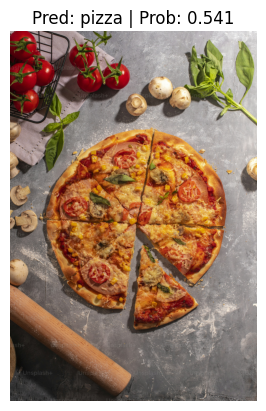

In [32]:
# TODO: Get an image of pizza/steak/sushi
pred_and_plot_image(model=model_0,
                        image_path=pizza_image_path,
                        class_names=class_names,
                        image_size=(224, 224))

In [33]:
# Setup custom image path
not_pizza_image_path = data_path / "not_real_pizza"

# Download the image if it doesn't already exist
if not not_pizza_image_path.is_file():
    with open(not_pizza_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://images.unsplash.com/photo-1516658273235-6f3ff3b414d1?q=80&w=2787&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
        print(f"Downloading {not_pizza_image_path}...")
        f.write(request.content)
else:
    print(f"{not_pizza_image_path} already exists, skipping download.")

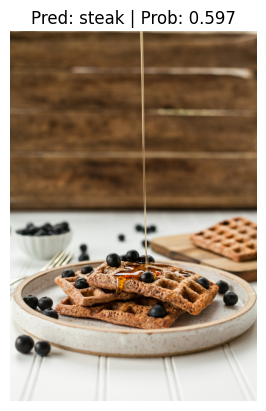

In [34]:
# TODO: Get an image of not pizza/steak/sushi
pred_and_plot_image(model=model_0,
                        image_path=not_pizza_image_path,
                        class_names=class_names,
                        image_size=(224, 224))

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [35]:
# TODO: Recreate a new model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [36]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_1.features.parameters():
    param.requires_grad = False

In [37]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [38]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model_1,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [39]:
# TODO: Train the model for 10 epochs
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6022 | train_acc: 0.7656 | test_loss: 0.5565 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5411 | train_acc: 0.9258 | test_loss: 0.5279 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5493 | train_acc: 0.8086 | test_loss: 0.5291 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.5725 | train_acc: 0.7969 | test_loss: 0.4947 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5219 | train_acc: 0.7969 | test_loss: 0.4207 | test_acc: 0.8655
[INFO] Total training time: 32.494 seconds


[INFO] Couldn't find helper_functions.py, downloading...


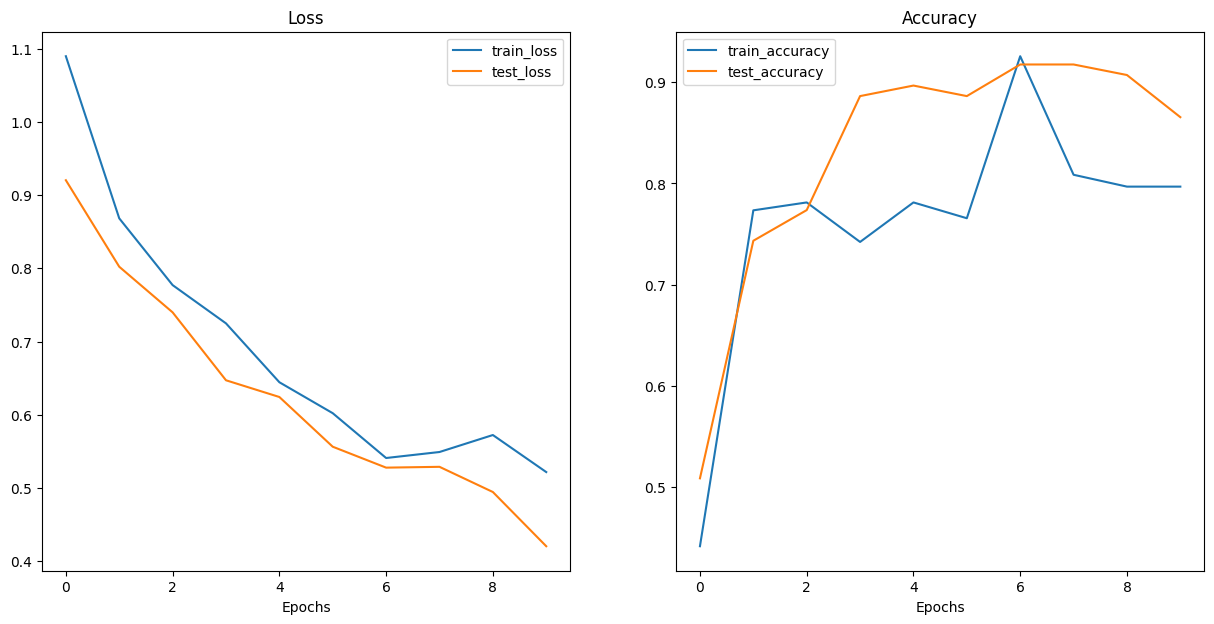

In [40]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_1_results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [41]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [42]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [43]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b8b6fcbf100>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [44]:
# TODO
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [45]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

In [46]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [47]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model_2,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Train a model with 20% of the data

In [48]:
# TODO
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9747 | train_acc: 0.5667 | test_loss: 0.6472 | test_acc: 0.8949
Epoch: 2 | train_loss: 0.7067 | train_acc: 0.8167 | test_loss: 0.5291 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.5866 | train_acc: 0.8271 | test_loss: 0.4519 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4555 | train_acc: 0.8917 | test_loss: 0.4089 | test_acc: 0.8881
Epoch: 5 | train_loss: 0.4520 | train_acc: 0.8896 | test_loss: 0.3788 | test_acc: 0.9068
Epoch: 6 | train_loss: 0.4271 | train_acc: 0.8396 | test_loss: 0.3534 | test_acc: 0.9006
Epoch: 7 | train_loss: 0.4157 | train_acc: 0.8396 | test_loss: 0.3159 | test_acc: 0.9193
Epoch: 8 | train_loss: 0.3935 | train_acc: 0.8500 | test_loss: 0.3192 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3163 | train_acc: 0.8938 | test_loss: 0.3025 | test_acc: 0.9040
Epoch: 10 | train_loss: 0.3488 | train_acc: 0.9042 | test_loss: 0.2699 | test_acc: 0.9318
[INFO] Total training time: 34.532 seconds


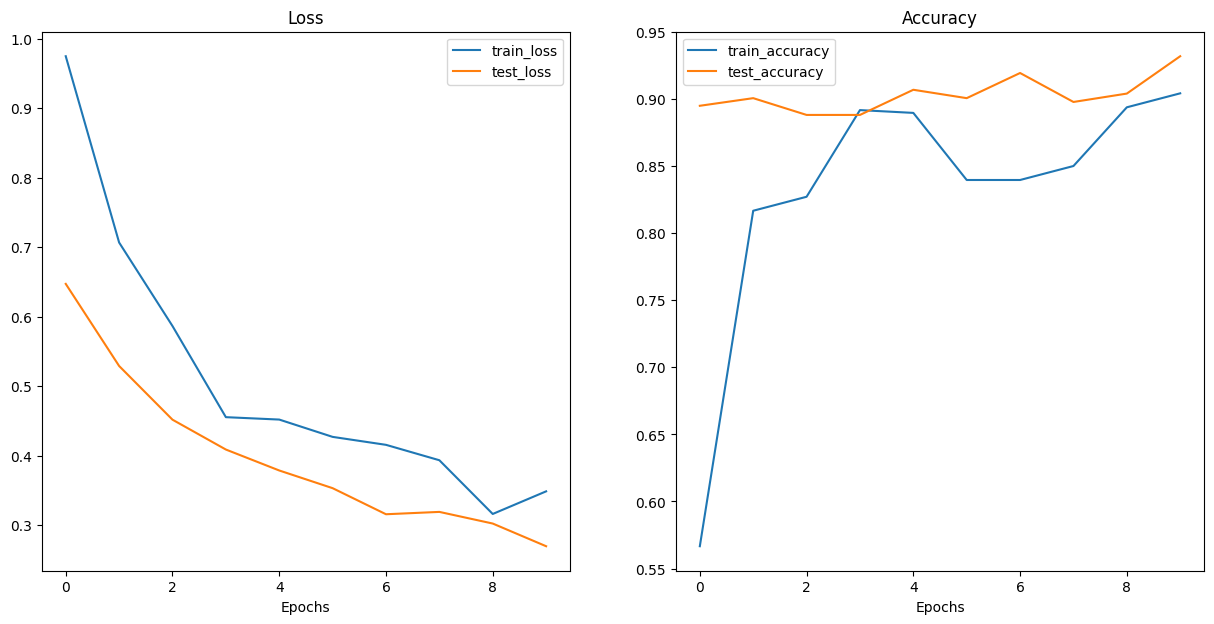

In [49]:
# Plot the loss curves of our model
plot_loss_curves(model_2_results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [51]:
# TODO
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights
model_3 = torchvision.models.efficientnet_b2(weights=weights).to(device)

model_3 # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 153MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [53]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_3.features.parameters():
    param.requires_grad = False

In [56]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [60]:
# # Do a summary *after* freezing the features and changing the output classifier layer
summary(model_3,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [66]:
len(train_dataloader.dataset), len(test_dataloader.dataset)

(225, 75)

In [63]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1152 | train_acc: 0.3359 | test_loss: 0.9501 | test_acc: 0.6809
Epoch: 2 | train_loss: 0.8991 | train_acc: 0.6602 | test_loss: 0.8787 | test_acc: 0.7737
Epoch: 3 | train_loss: 0.8031 | train_acc: 0.7930 | test_loss: 0.8088 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7652 | train_acc: 0.7305 | test_loss: 0.7099 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.6519 | train_acc: 0.8008 | test_loss: 0.7030 | test_acc: 0.8561
[INFO] Total training time: 9.501 seconds


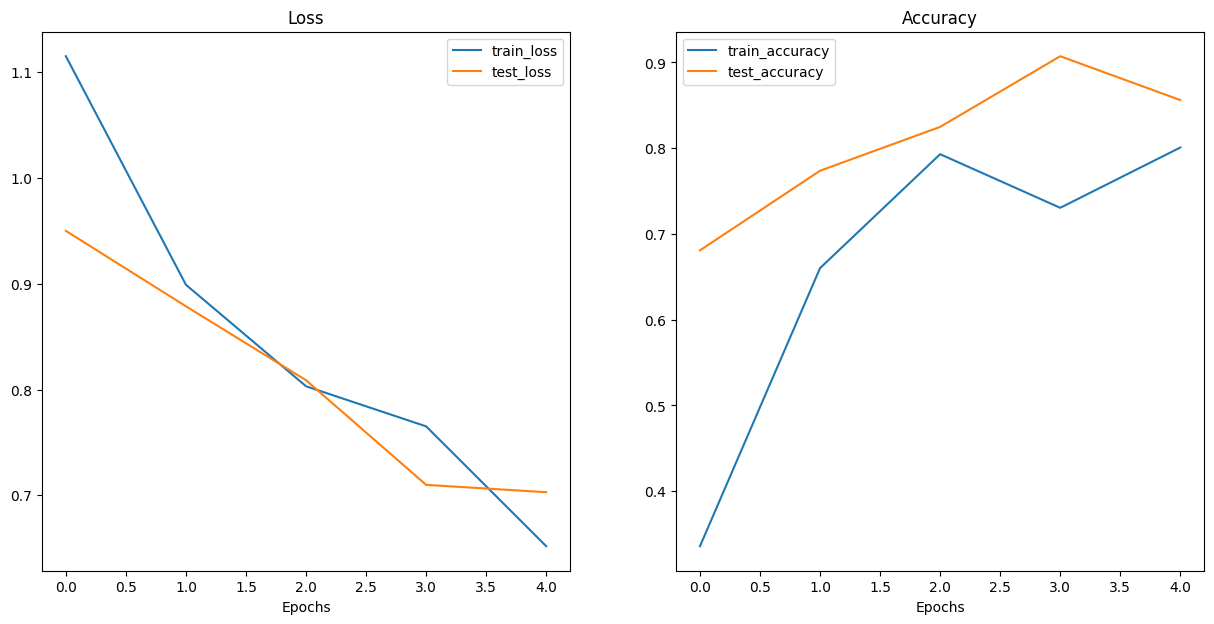

In [64]:
# Plot the loss curves of our model
plot_loss_curves(model_3_results)